# Parameters Estimation :

### this is the first attempt in running the MH algorithm using real data for the parameters estimation, i took it out of the main notebook cz its messy and need a lot of revision. 
### Note: i am also working on another version of the code using matrices only for better result, i will send it ASAP.



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy
from scipy.stats import truncnorm # for truncated normal distribution


In [19]:
def LotkaVolterra(u,t, alpha, beta,gamma,delta):
    x,y = u
    dxdt = alpha*x-beta*x*y
    dydt = -gamma*y +delta *x*y
    return [dxdt,dydt]
# let us define a function that generate data for the forward version problem given set of parameter values 
def forwardProblem(time_interval =25, time_points =  25, parms = [0.55,0.028,0.84,0.026, 33, 6]):
  alpha,beta,gamma,delta,Xt_0,Yt_0 = [z for z in parms]
  t = np.linspace(0,time_interval,time_points)
  forward_sol = odeint(LotkaVolterra,[Xt_0,Yt_0],t,args=(alpha,beta,gamma,delta))    
  df = pd.DataFrame({'time': t, 'X': forward_sol[:, 0], 'Y': forward_sol[:, 1]})
  # for now we use fixed values for the hyperparameters 
  sigma_X= np.std(df.X)
  sigma_Y= np.std(df.Y)
  return df, sigma_X, sigma_Y
# Let us generate some data using some fixed parameter values 
df, sigma_X, sigma_Y = forwardProblem()
print("Variance of X=", sigma_X, " and  varaince of Y=", sigma_Y)


df.head()

Variance of X= 18.14196011171221  and  varaince of Y= 14.036026223887818


,time,X,Y
0,0.000000,33.000000,6.000000
1,1.041667,48.450583,7.464737
2,2.083333,63.786277,14.454308
3,3.125000,57.675076,33.784690
4,4.166667,29.888911,45.874998


In [53]:
# another approach for likelihood calculations

def observation(df, sigma_X, sigma_Y):
    X_l = np.zeros(len(df))
    Y_l = np.zeros(len(df))
    for i in range(len(X_l)):
        X_l[i] = stats.lognorm.rvs(scale=df['X'][i], s=sigma_X, size=1)
        Y_l[i] = stats.lognorm.rvs(scale=df['Y'][i], s=sigma_Y, size=1)
    df['X_l'] = X_l
    df['Y_l'] = Y_l
    return df

data = observation(df,0.25,0.25)

def computeLikelihood2(data, parmeters): 
    alpha,beta,gamma,delta,Xt_0,Yt_0, sigma_X, sigma_Y  = parmeters
    sol, _,_  = forwardProblem(time_interval= len(data), time_points= len(data), parms = [ alpha,beta,gamma,delta, Xt_0,Yt_0])
    lik = 0.0
    for i in range(len(data['time'])):
        lik += stats.lognorm.logpdf(data['X_l'][i], scale=sol['X'][i], s=sigma_X)
        lik += stats.lognorm.logpdf(data['Y_l'][i], scale=sol['Y'][i], s=sigma_Y) 
    return -lik/len(data)

p = [0.1,.028,.84,.026,33, 6, 0.25, 0.25]
computeLikelihood2(data, p)

34.71758282901723

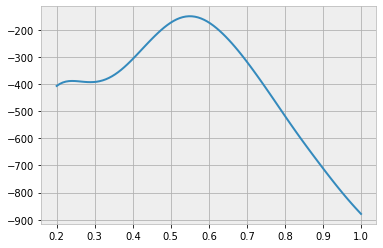

In [22]:
alpha = np.linspace(0.2, 1, 100)
log_like = np.zeros(len(alpha))
for i in range(len(alpha)):
    log_like[i] = computeLikelihood(df, [alpha[i], 0.028, 0.84, 0.026, 33, 6, 0.25, 0.25])
plt.plot(alpha, log_like)
plt.show()

In [28]:

import pints
class LotkaVolterraLogPDF(pints.LogPDF):
    def __init__(self, df_obs, Xt0=33, Yt0=6, sigma_X=0.25, sigma_Y=0.25):
        self._data = data
        self._Xt0 = Xt0 
        self._Yt0 = Yt0
        self._sigma_X = sigma_X
        self._sigma_Y = sigma_Y

    def __call__(self, x):
        data = self._data
        Xt0 = self._Xt0
        Yt0 = self._Yt0
        sigma_X = self._sigma_X
        sigma_Y = self._sigma_Y
        return computeLikelihood(data, [x[0], x[1], x[2], x[3],
                                              Xt0, Yt0, sigma_X, sigma_Y])

    def n_parameters(self):
        return 4

In [29]:
model = LotkaVolterraLogPDF(df)
nchains = 4
xs = [[0.6, 0.02, 1.0, 0.03]]*4
mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(200)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0.5       0          0:00.1
2     12     0         0         0.333     0          0:00.1
3     16     0.25      0         0.5       0          0:00.1


C:\Users\Mohanned Khairy\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20    84     0.19      0.143     0.143     0.0952     0:00.7
40    164    0.0976    0.0732    0.122     0.0976     0:01.3
60    244    0.0656    0.0656    0.0984    0.0656     0:01.9
80    324    0.0494    0.0617    0.0864    0.0494     0:02.5
100   404    0.0396    0.0495    0.0693    0.0495     0:03.2
120   484    0.0331    0.0413    0.0579    0.0496     0:03.8
140   564    0.0284    0.0355    0.0496    0.0426     0:04.4
160   644    0.0248    0.0311    0.0435    0.0373     0:05.0
180   724    0.0221    0.0276    0.0387    0.0331     0:05.6
Initial phase completed.
200   804    0.0199    0.0249    0.0348    0.0299     0:06.3
220   884    0.0362    0.0498    0.0588    0.0588     0:06.9
240   964    0.083     0.0996    0.104     0.0954     0:07.5
260   1044   0.13      0.123     0.126     0.126      0:08.1
280   1124   0.142     0.13879   0.146     0.149      0:08.7
300   1204   0.166113  0.146     0.163     0.159      0:09.3
320   1284   0.171     0.15      0.178     0.165109   0:09.9

In [30]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.51    0.07    0.40    0.46   0.50   0.54   0.74     1.21    88.99  1.48
param 2  0.03    0.01    0.02    0.02   0.03   0.03   0.04     1.21    96.16  1.60
param 3  0.94    0.12    0.67    0.87   0.94   1.01   1.17     1.20    73.12  1.22
param 4  0.03    0.00    0.02    0.03   0.03   0.03   0.04     1.15    68.72  1.14


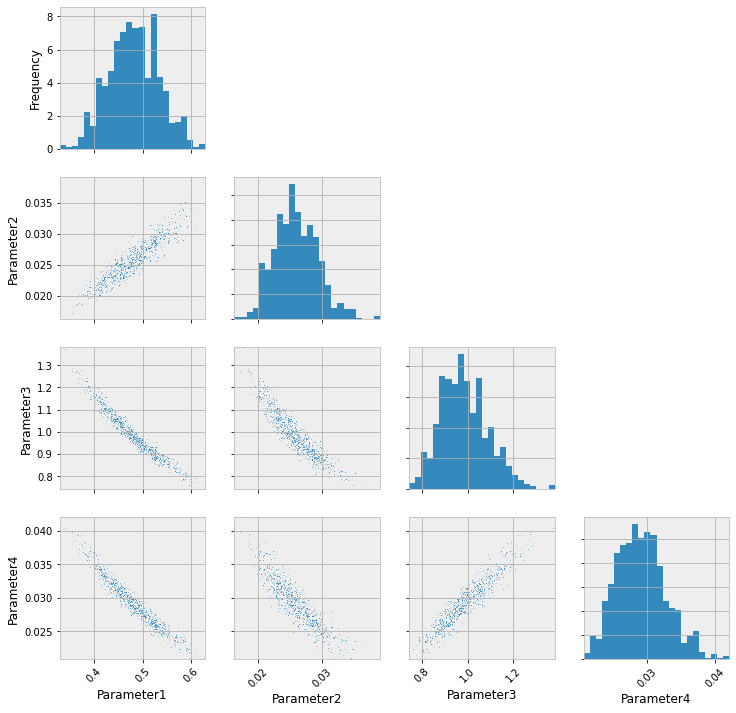

In [31]:
import pints.plot

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains[:, 1000:]), kde=False)

# Show graphs
plt.show()

In [32]:
log_prior = pints.UniformLogPrior([0, 0, 0, 0],
                                  [2, 0.1, 2.0, 0.2])
xs = log_prior.sample(nchains)
mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(200)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0         0          0:00.1
2     12     0         0         0.333     0.333      0:00.1
3     16     0         0         0.5       0.25       0:00.2
20    84     0.238     0.238     0.238     0.238      0:00.8
40    164    0.195122  0.317     0.244     0.171      0:01.5
60    244    0.164     0.262     0.23      0.115      0:02.3
80    324    0.123     0.235     0.185     0.0864     0:03.0
100   404    0.099     0.198     0.178     0.0792     0:03.7
120   484    0.0826    0.174     0.149     0.0744     0:04.4
140   564    0.078     0.149     0.135     0.0638     0:05.1
160   644    0.0683    0.149     0.118     0.0559     0:05.8
180   724    0.0663    0.133     0.105     0.0497     0:06.5
Initial phase completed.
200   804    0.0597    0.

In [33]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.62    0.54    0.06    0.10   0.46   0.95   2.02     1.78    13.29  0.20
param 2  0.05    0.05    0.00    0.00   0.04   0.08   0.21     1.69    13.98  0.21
param 3  4.56    2.12    1.38    2.58   4.21   6.66   7.75     2.31    12.52  0.19
param 4  0.13    0.06    0.04    0.08   0.13   0.19   0.23     2.35    12.59  0.19


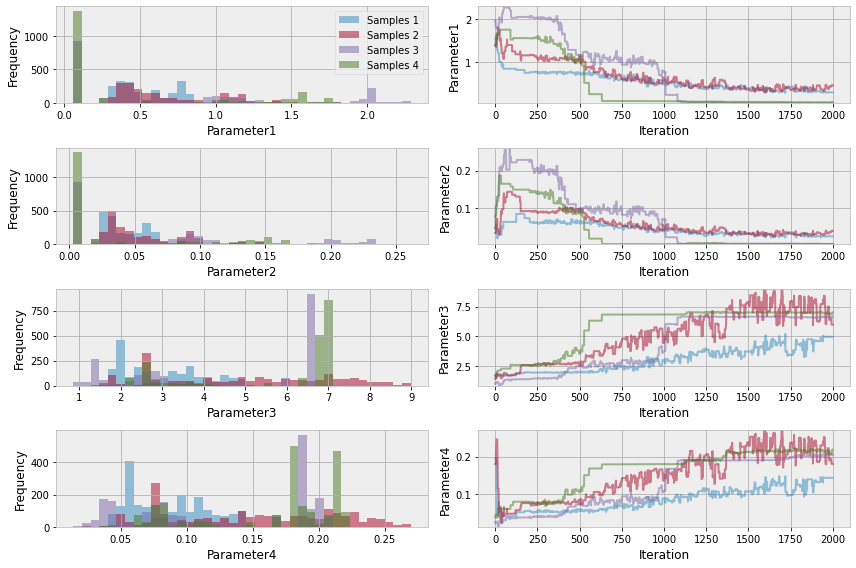

In [34]:
import pints.plot

pints.plot.trace(chains)
plt.show()

In [51]:
# Now let us definie prior distributions
alpha_prior = truncnorm(0, 1, 0.5, 0.1)
beta_prior = truncnorm(0, 1, 0.5, 0.1)
delta_prior = truncnorm(0, 1, 0.5, 0.1)
gamma_prior = truncnorm(0, 1, 0.5, 0.1)
 # this is turncated normal distribution of mean 0.5 and std =0.1, and generates random numbers between a=0, and b = 1
 # you change this as you like
# beta_prior = .... (you should compelte the list)
# define the posterior density, which you call it target. 
# note that we are going to use different proir distributions, therefore we should defined a posterior for each priors. Though this is not the optimal implementations
# Here I define the for alpha proior
def alphaTarget(data, parms):
    posterior = computeLikelihood(data, parms) - alpha_prior.logpdf(parms[0])
    return posterior
def betaTarget(data, parms):
    posterior = computeLikelihood(data, parms) - alpha_prior.logpdf(parms[1])
    return posterior
def deltaTarget(data, parms):
    posterior = computeLikelihood(data, parms) - alpha_prior.logpdf(parms[2])
    return posterior
def gammaTarget(data, parms):
    posterior = computeLikelihood(data, parms) - alpha_prior.logpdf(parms[3])
    return posterior
# An example
alphaTarget(data, [0.551,.028,.84,.026,33, 6, 0.25, 0.25])

-151.71722367803645

In [49]:
# Now put all together 
def runSimulation(data, niters =100, step_size = 0.01):
  burn_in = niters//2
  σx = np.std(data.X) # varaince of the predator's data
  σy = np.std(data.Y) # varaince of the pray's data

  α = alpha_prior.rvs()
  β = beta_prior.rvs()
  γ = gamma_prior.rvs()
  δ = delta_prior.rvs()
  
  # initail  random value for alpha parameter, and likewise for the remaining parameters 
  init_parms = [α, β,γ,δ]
  hyper_parms = [ 19.58, 30.09, σx, σy] # I kept the values of other parameters the same except alph

  chain = np.zeros((niters+1, 4)) # create a container to keep the samples
  chain[0,:] = init_parms
  acceptance_vector = len(init_parms)*[0]
  parms = copy.deepcopy(chain[0,:])
  
  for i in range(niters):
    for j in range(4): # 
      current_parms = copy.deepcopy(chain[i,:])
      if j == 0:
        #for alpha
        α_new = current_parms[j] + step_size*stats.norm.rvs() 
        new_parms = copy.deepcopy(current_parms)
        new_parms[j] = α_new
        parms = list(current_parms) + list(hyper_parms)
        parms2 =  list(new_parms) + list(hyper_parms)
        p1 = alphaTarget(data,  parms)
        p2 = alphaTarget(data,  parms2)
        if p1 != 0 and p2 != 0:
          ρ = min(1, p2/p1)
          if np.random.uniform() < ρ:
            acceptance_vector[j] += 1
            chain[i+1,j] = α_new
          else:
            chain[i+1,j] = current_parms[j]
        else:
          chain[i+1,j] = current_parms[j]
      else:
        chain[i+1,j] = init_parms[j]
        ###########################################
        if j == 1:
          #for betta
          β_new = current_parms[j] + step_size*stats.norm.rvs() 
          new_parms = copy.deepcopy(current_parms)
          new_parms[j] = β_new
          parms = list(current_parms) + list(hyper_parms)
          parms2 =  list(new_parms) + list(hyper_parms)
          p1 = betaTarget(data,  parms)
          p2 = betaTarget(data,  parms2)
          if p1 != 0 and p2 != 0:
            ρ = min(1, p2/p1)
            if np.random.uniform() < ρ:
              acceptance_vector[j] += 1
              chain[i+1,j] =  β_new
            else:
              chain[i+1,j] = current_parms[j]
          else:
            chain[i+1,j] = current_parms[j]
        else:
          chain[i+1,j] = init_parms[j]
        ###########################################
          if j == 2:
            #for gamma
            γ_new = current_parms[j] + step_size*stats.norm.rvs() 
            new_parms = copy.deepcopy(current_parms)
            new_parms[j] = γ_new
            parms = list(current_parms) + list(hyper_parms)
            parms2 =  list(new_parms) + list(hyper_parms)
            p1 = gammaTarget(data,  parms)
            p2 = gammaTarget(data,  parms2)
            if p1 != 0 and p2 != 0:
              ρ = min(1, p2/p1)
              if np.random.uniform() < ρ:
                acceptance_vector[j] += 1
                chain[i+1,j] = γ_new
              else:
                chain[i+1,j] = current_parms[j]
            else:
                chain[i+1,j] = current_parms[j]
          else:
            chain[i+1,j] = init_parms[j]  
          ###########################################         
            if j == 3:
                #for delta
                δ_new = current_parms[j] + step_size*stats.norm.rvs() 
                new_parms = copy.deepcopy(current_parms)
                new_parms[j] =  δ_new
                parms = list(current_parms) + list(hyper_parms)
                parms2 =  list(new_parms) + list(hyper_parms)
                p1 = deltaTarget(data,  parms)
                p2 = deltaTarget(data,  parms2)
                if p1 != 0 and p2 != 0:
                  ρ = min(1, p2/p1)
                  if np.random.uniform() < ρ:
                    acceptance_vector[j] += 1
                    chain[i+1,j] =  δ_new
                  else:
                    chain[i+1,j] = current_parms[j]
                else:
                  chain[i+1,j] = current_parms[j]
            else:
              chain[i+1,j] = init_parms[j]
        
        
  clean_chain = chain[-0:burn_in, :]
  print ("Efficiency = ", np.array(acceptance_vector)/niters)   
  return clean_chain
 

In [52]:
chain = runSimulation(data = data, niters = 1000, step_size=0.25)

C:\Users\Mohanned Khairy\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Mohanned Khairy\AppData\Local\Temp\ipykernel_15132\3012405486.py:34: RuntimeWarning: invalid value encountered in double_scalars
  ρ = min(1, p2/p1)
C:\Users\Mohanned Khairy\AppData\Local\Temp\ipykernel_15132\3012405486.py:55: RuntimeWarning: invalid value encountered in double_scalars
  ρ = min(1, p2/p1)
C:\Users\Mohanned Khairy\AppData\Local\Temp\ipykernel_15132\3012405486.py:76: RuntimeWarning: invalid value encountered in double_scalars
  ρ = min(1, p2/p1)
C:\Users\Mohanned Khairy\AppData\Local\Temp\ipykernel_15132\3012405486.py:97: RuntimeWarning: invalid value encountered in double_scalars
  ρ = min(1, p2/p1)


Efficiency =  [1. 1. 1. 1.]


In [48]:
chain

array([[0.57394308, 0.55904288, 0.59044434, 0.55948668],
       [0.57858864, 0.55808958, 0.57451012, 0.52086069],
       [0.54214964, 0.5367536 , 0.59434921, 0.50221118],
       ...,
       [2.23305298, 0.97583315, 0.97309087, 1.73490909],
       [2.22466391, 1.09879636, 1.05590261, 1.71026584],
       [2.29505407, 1.14085624, 1.11604999, 1.73449773]])

In [ ]:
α_average = np.average(chain[:,0])
β_average = np.average(chain[:,1])
δ_average = np.average(chain[:,2])
γ_average = np.average(chain[:,3]) 

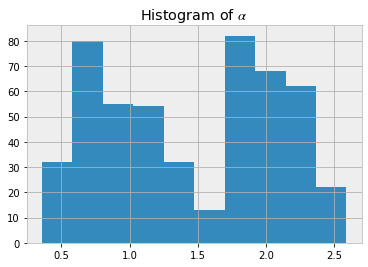

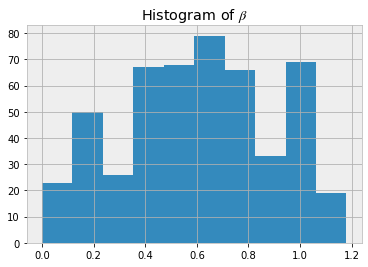

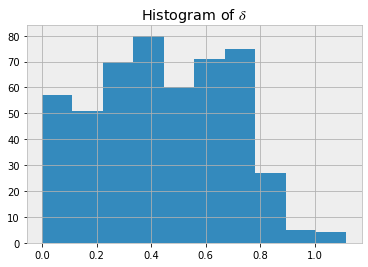

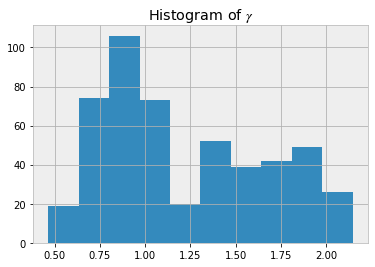

In [44]:
init_parms = ['α', 'β', 'δ', 'γ']
for i in range(4):
        name = init_parms[i]
        plt.hist(chain[:,i])
        plt.title("Histogram of ${{%s}}$"%(name))
        plt.show()

## to check if there is any correlation between the parameters :


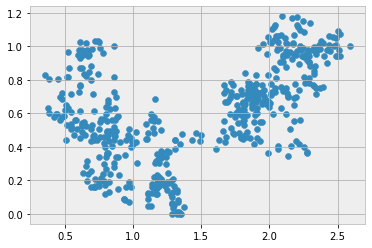

In [45]:
plt.scatter(chain[:,0],chain[:,1])

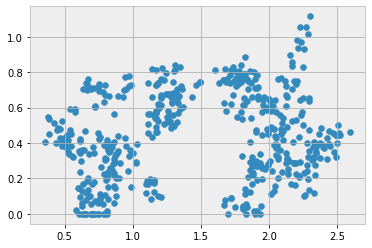

In [46]:
plt.scatter(chain[:,0],chain[:,2])


In [19]:
chains_long = np.vstack(chains[:, 1000:])
nsamples = 100
idx = np.random.randint(len(chains_long), size=nsamples)
chains_long = chains_long[idx, ]
times = np.linspace(0, 25, 1001)


for i in range(nsamples):
    temp = lotka_volterra_solve(times,
                                chains_long[i, 0], chains_long[i, 1],
                                chains_long[i, 2], chains_long[i, 3],
                                33, 6)
    temp['replicate'] = str(i)
    if i == 0:
        big_df = temp
    else:
        big_df = big_df.append(temp)

NameError: name 'chains' is not defined

In [2]:
import numpy as np
np.random.seed(0)

The acceptance rate was 44.71% 

Beta(0) mean prediction: 0.6734, 95% CI: (0.4262,0.9206), true_beta: 0.8 

Beta(1) mean prediction: 0.6494, 95% CI: (0.4128,0.886), true_beta: 0.7 

Beta(2) mean prediction: 0.4812, 95% CI: (0.2566,0.7058), true_beta: 0.4 

Beta(3) mean prediction: 0.4281, 95% CI: (0.1807,0.6755), true_beta: 0.6 


 BETA(0) 



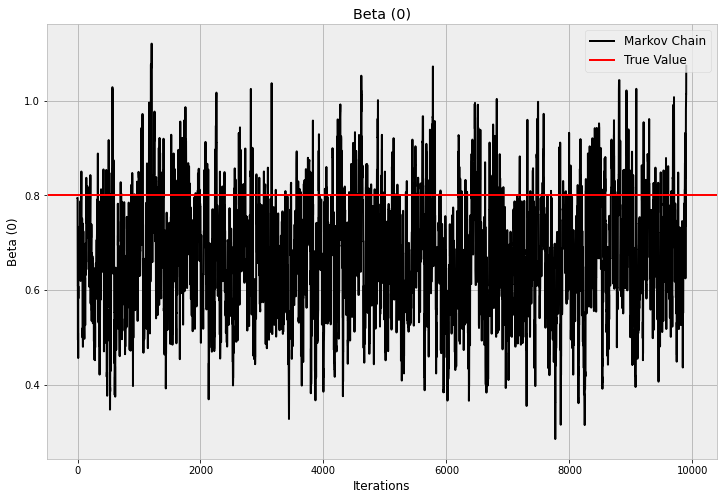


 BETA(1) 



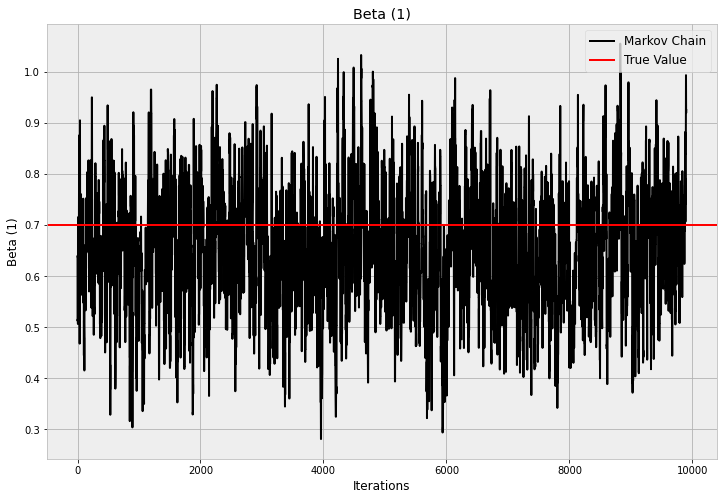


 BETA(2) 



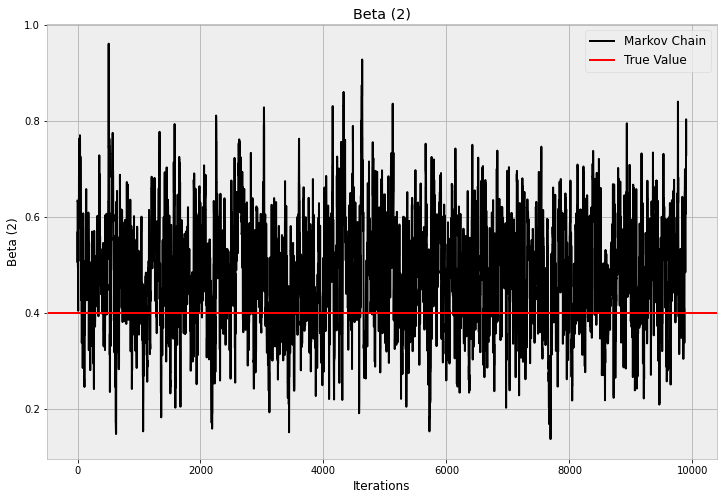


 BETA(3) 



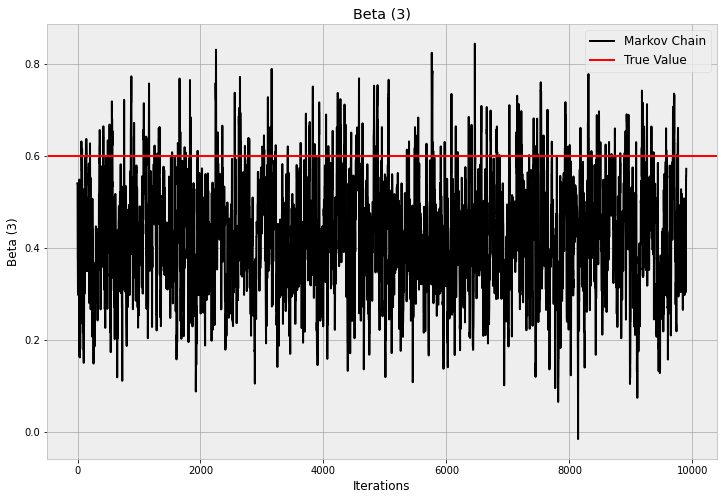


 BETA(0) 



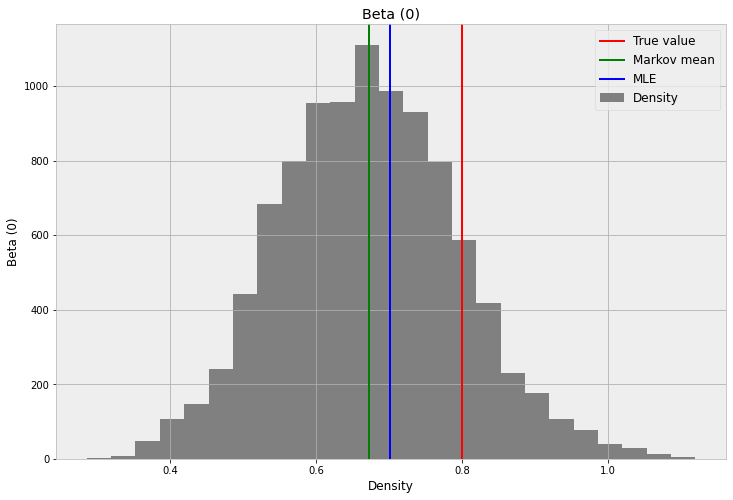


 BETA(1) 



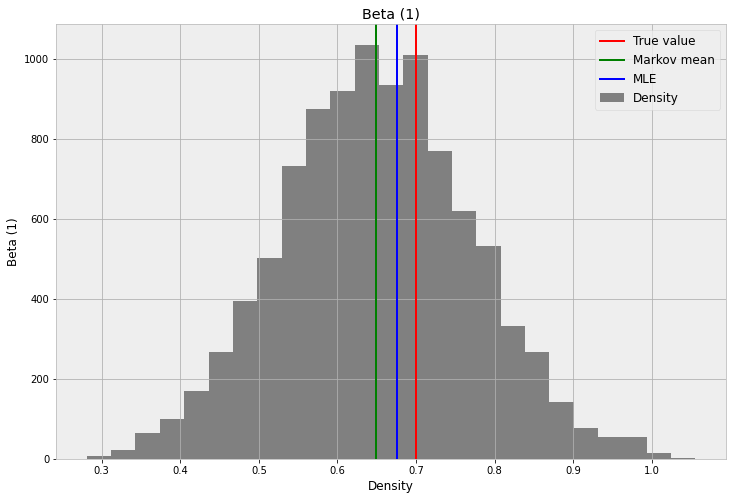


 BETA(2) 



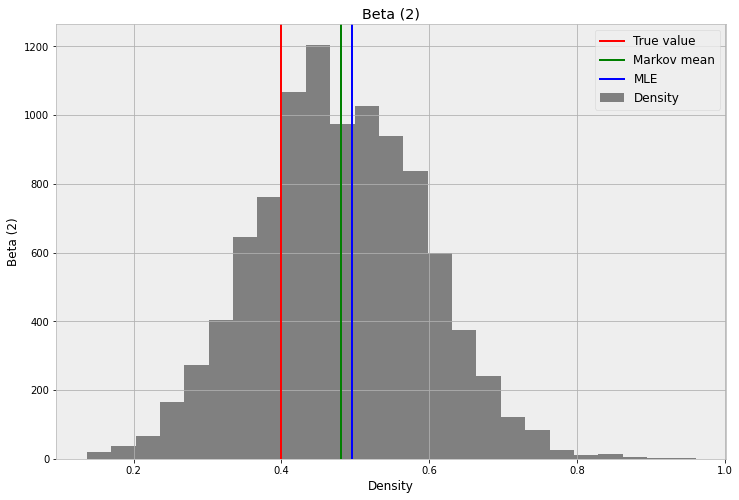


 BETA(3) 



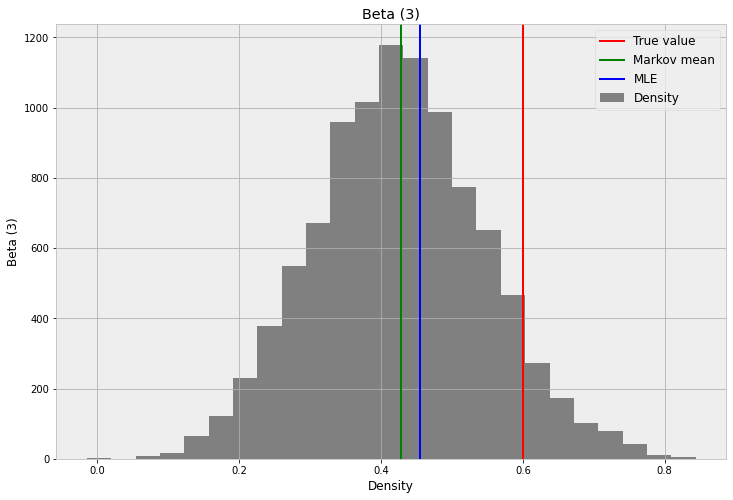

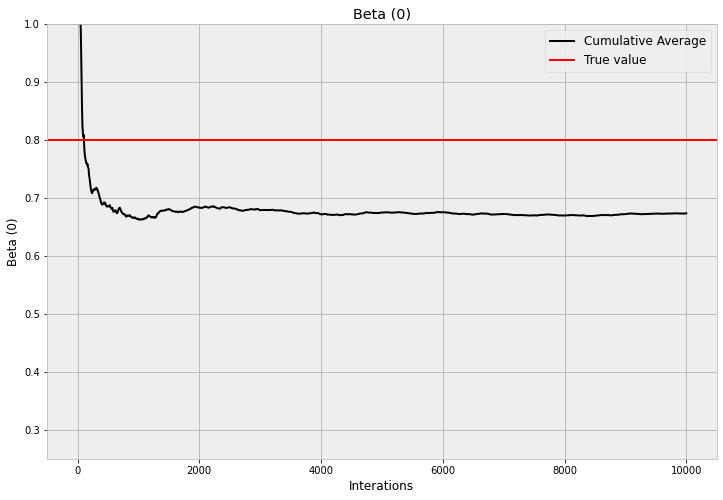

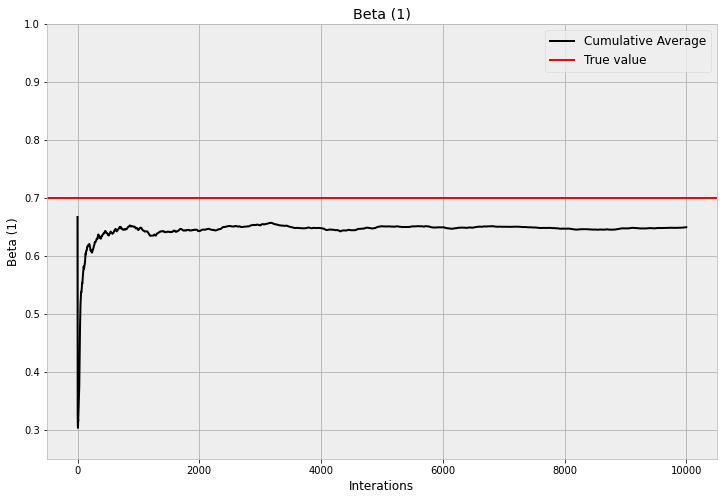

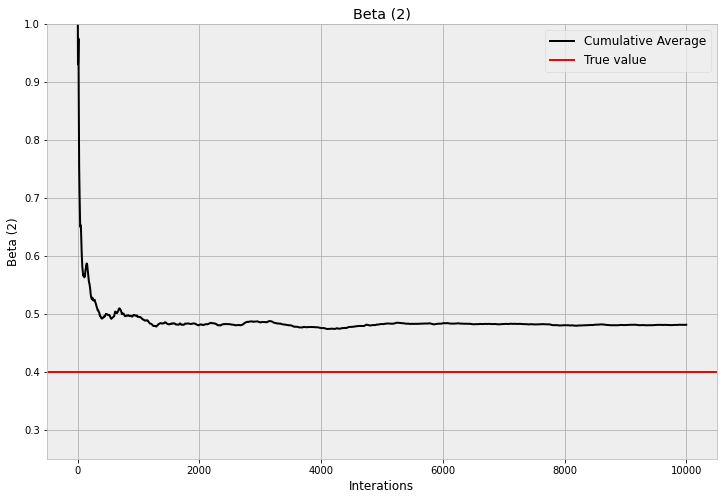

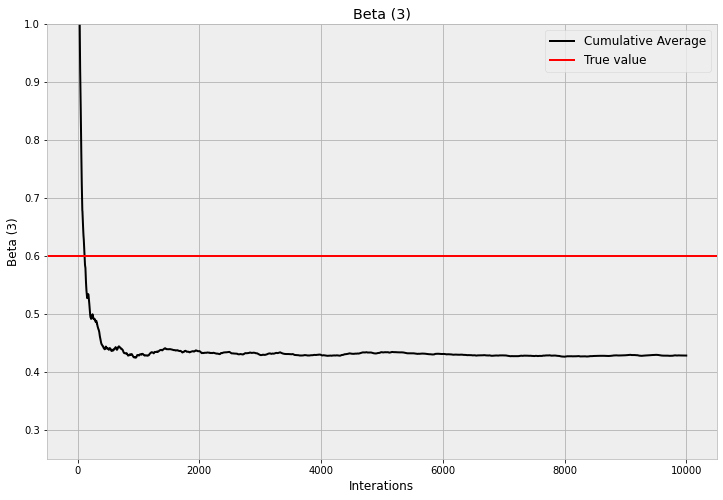

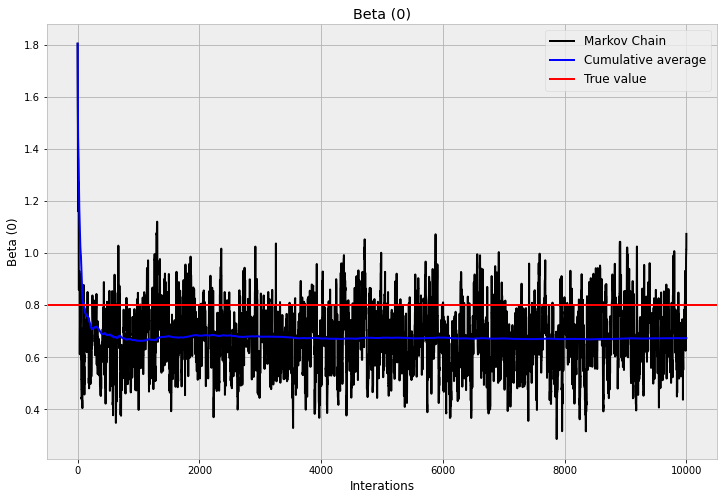

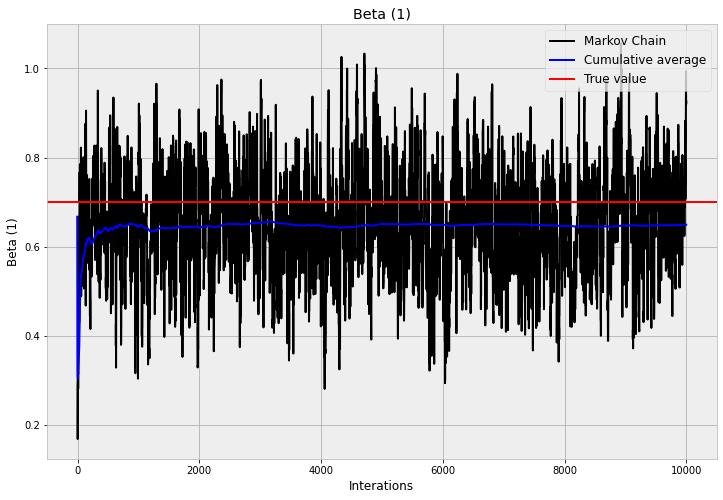

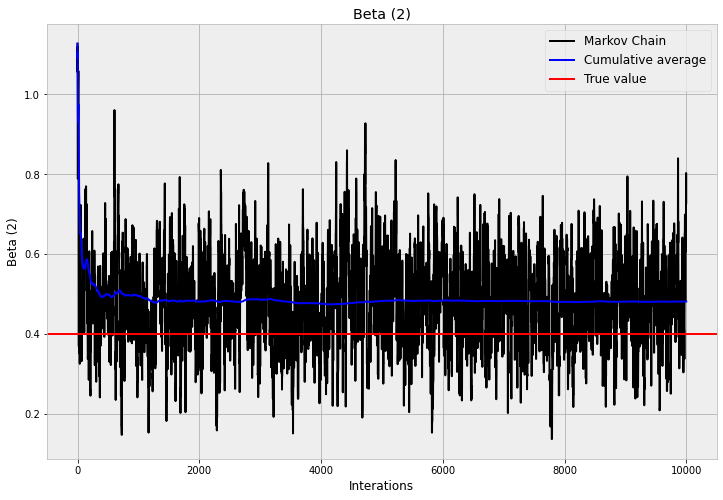

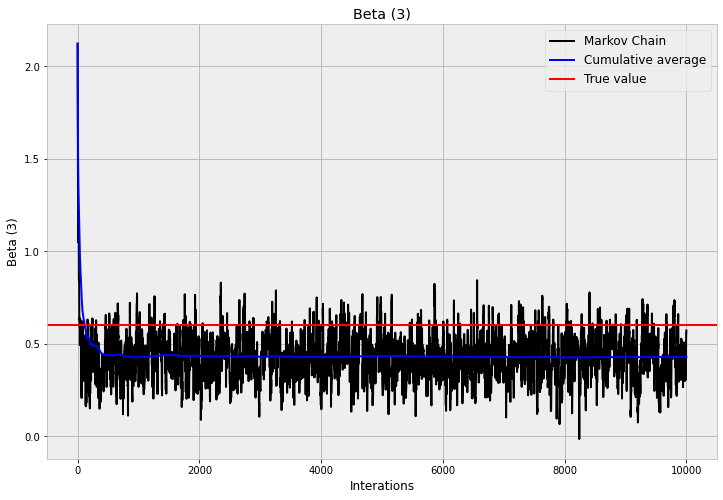


 BETA(0) 



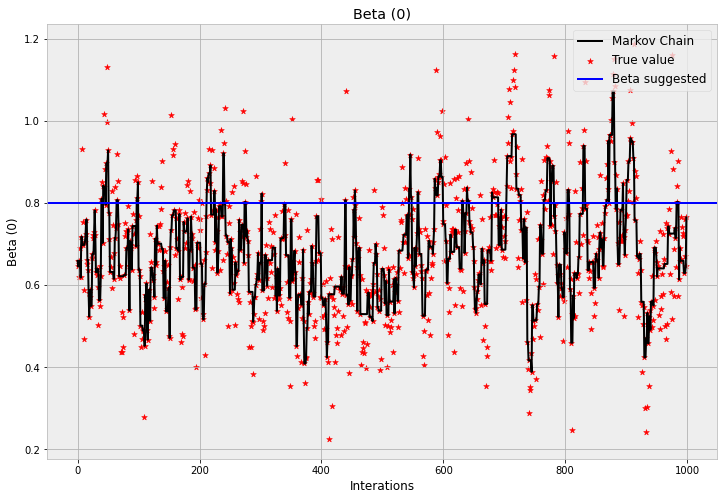


 BETA(1) 



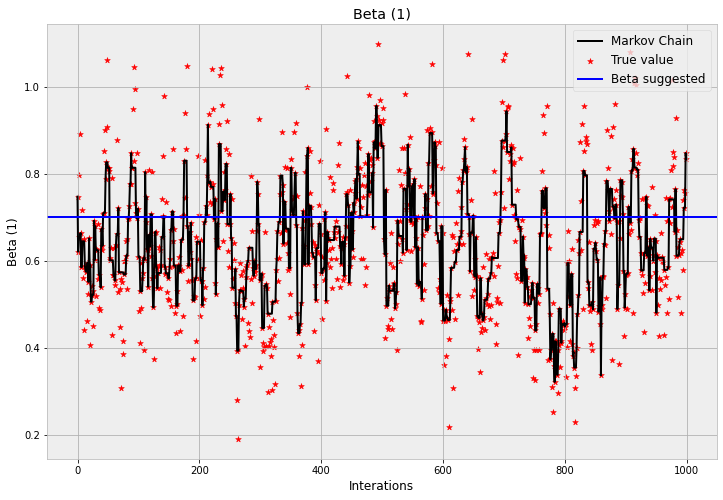


 BETA(2) 



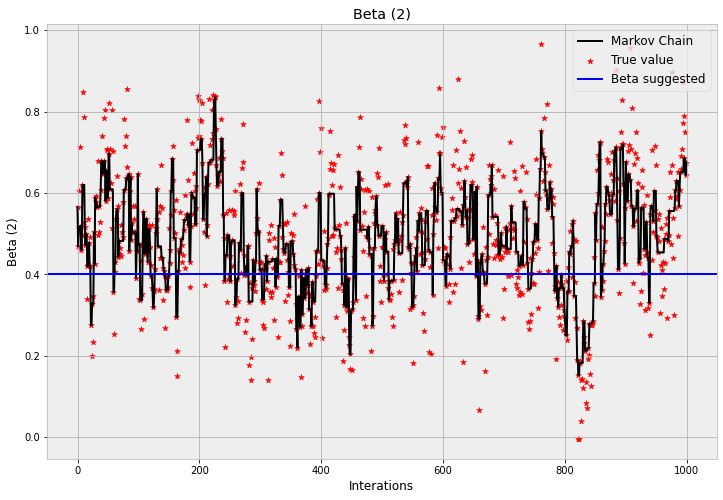


 BETA(3) 



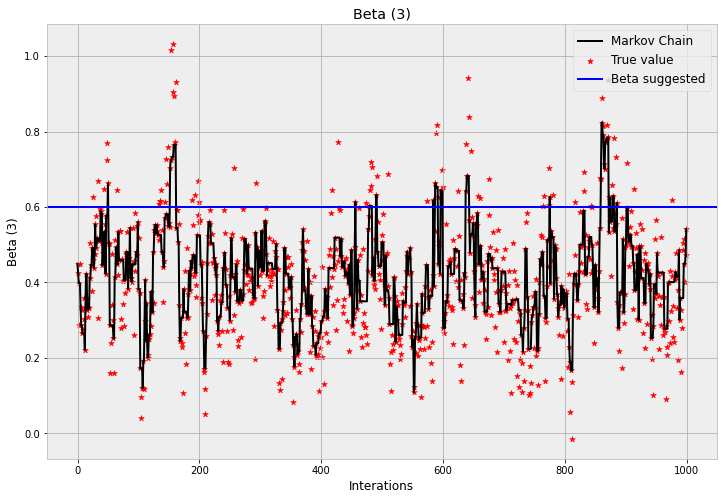

The ACF matrix for Beta0 is [1.         0.88985519 0.79390288 0.70985539 0.63720707 0.57345198
 0.51363064 0.46103343 0.4110423  0.36872014 0.33302847]

The ACF matrix for Beta1 is [1.         0.87241407 0.76773399 0.68130011 0.60380824 0.53628092
 0.48150463 0.43204061 0.38343857 0.33937352 0.30079147]

The ACF matrix for Beta2 is [1.         0.86849518 0.75765642 0.65611736 0.57084015 0.49201116
 0.42392106 0.36636582 0.32169753 0.28614324 0.25384896]

The ACF matrix for Beta3 is [1.         0.88229469 0.78019833 0.68591554 0.59757862 0.51956421
 0.45092982 0.39308821 0.34478489 0.30470133 0.26076978]


 The ACF plot for Beta0 is: 



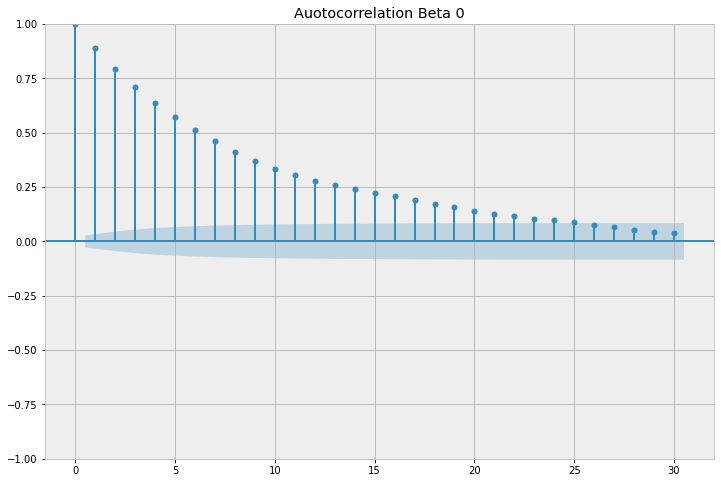


 The ACF plot for Beta1 is: 



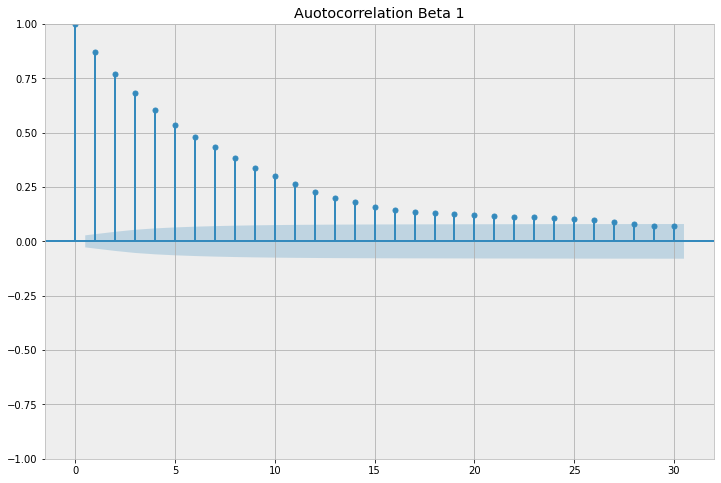


 The ACF plot for Beta2 is: 



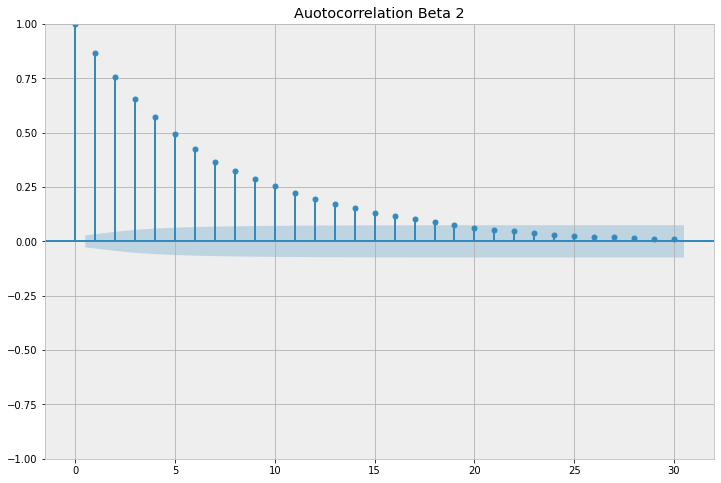


 The ACF plot for Beta3 is: 



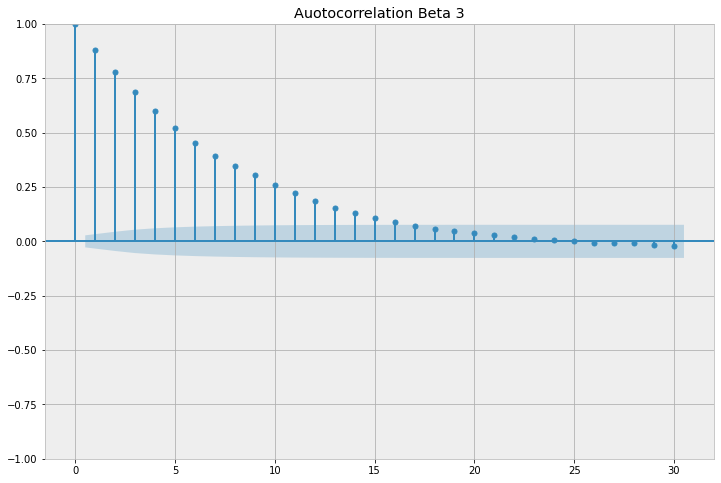


 The ACF plot for Beta0 is: 



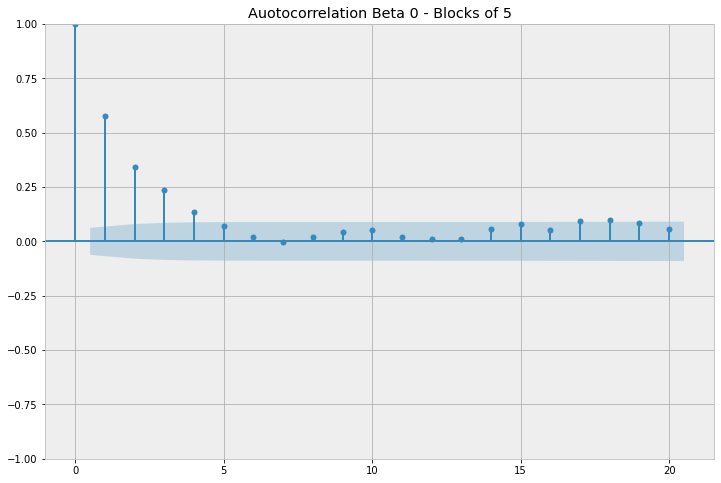


 The ACF plot for Beta1 is: 



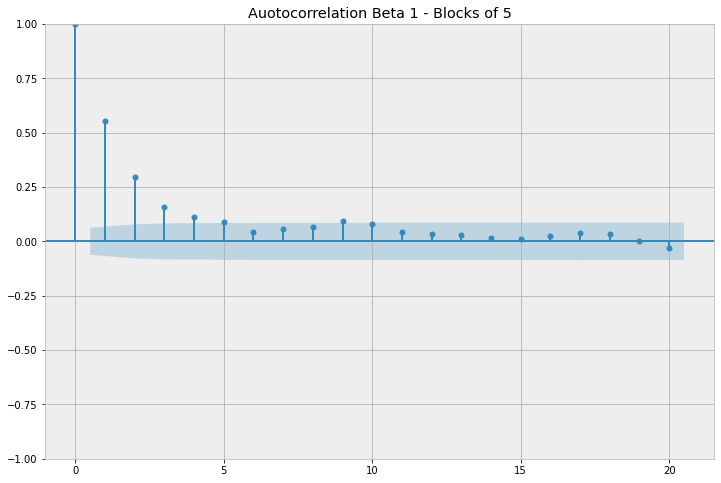


 The ACF plot for Beta2 is: 



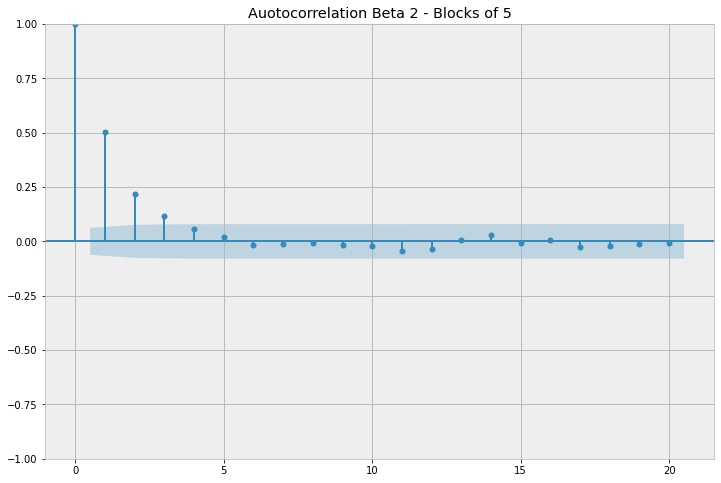


 The ACF plot for Beta3 is: 



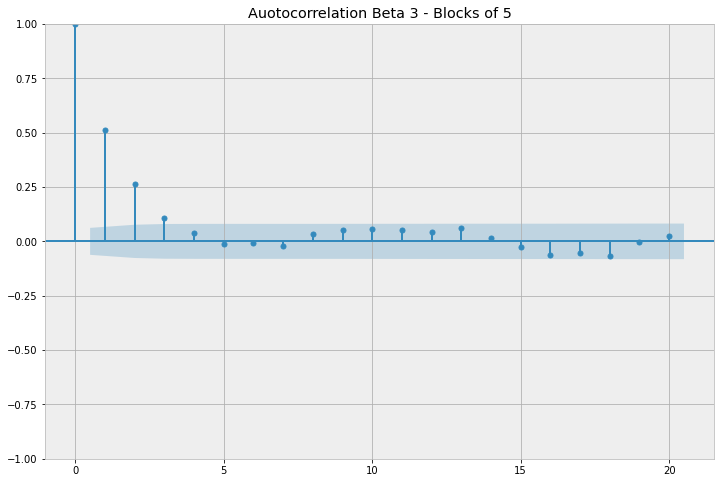

Optimization terminated successfully.
         Current function value: 0.471599
         Iterations 6
MLE estimate: 

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                         Probit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sun, 24 Apr 2022   Pseudo R-squ.:                  0.2564
Time:                        02:04:02   Log-Likelihood:                -94.320
converged:                       True   LL-Null:                       -126.84
Covariance Type:            nonrobust   LLR p-value:                 4.938e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7017      0.121      5.808      0.000       0.465       0.939
x1           

In [3]:
################### IMPORT ####################################################
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, bernoulli
from statsmodels.discrete.discrete_model import Probit
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
np.random.seed(0)


################### SIMULATED DATA ############################################
# simulated data
np.random.seed(0)
n = 200 # number of observations
k = 3 # number of explanatory variables

X = np.ones((n,k+1))
X[:,1:] = np.random.normal(loc=0,scale=1,size=k*n).reshape(n,k)
beta_true = np.matrix( [0.8,0.7,0.4,0.6]).T
sigma_true = 0.1
eta = np.dot(X,beta_true) + np.random.normal(loc=0, scale = sigma_true, size=(n,1))
Y =  bernoulli.rvs(p = norm.cdf(eta))

################### ALGORITHM #################################################

#Better perfomance to work in matrix form, avoid using loops
#PROOF: https://www.statlect.com/fundamentals-of-statistics/probit-model-maximum-likelihood
def probit_likelihood(beta, x, y):
    q = 2*y - 1
    eta = np.dot(x,beta)
    eta_q = np.multiply(q.T,eta)
    p = norm.cdf(eta_q)
    likehood = np.prod(p)
    return likehood

def beta_prior(beta, lambda0=10):
    mean = np.zeros(shape=(beta.shape[0],))
    cov = (1/lambda0) * np.identity(beta.shape[0])
    prior_distribution = multivariate_normal(mean=mean, cov=cov)
    return prior_distribution.pdf(beta)

def posterior(beta, x, y, lambda0=10):
    return beta_prior(beta, lambda0)*probit_likelihood(beta, x, y)

#Work in log form for numeric stability
def acceptance_probability(beta_new, beta_old, x, y, lambda0=10):
    posterior_new = posterior(beta_new, x, y, lambda0)
    posterior_old = posterior(beta_old, x, y, lambda0)
    logratio = np.log(posterior_new) - np.log(posterior_old)
    ratio = np.exp(logratio)
    return min(1, ratio)

#Fisher information for bernoulli Y with probit link
## Demidenko(2001) ("Computational aspects of probit model") & Graziani slides (Lecture 5, slide 7)
def Fisher_information_probit(beta,x):
    np.seterr(divide = 'ignore') ## avoid error while divide
    n,p = x.shape
    eta = np.dot(x,beta)
    numerator = norm.pdf(eta)**2
    denominator = (norm.cdf(eta))*(1.0001-norm.cdf(eta))
    value = np.divide(numerator, denominator)
    ## Set 1 when the value is 'inf', 1 = neutral multiplier
    ##value[value==np.inf] = 1 
    W = value * np.identity(n)
    I = x.T @ W @ x
    invI = np.linalg.inv(I)
    return invI

### Algorithm inverse fisher variance
def metropolsH_randomWalk_fisher(Y,X,lambda0 = 10, interations=5000, start=0, tau=1):
    n,p = X.shape
    np.random.seed(0)
    beta_tried = np.zeros(shape=(p,interations))
    beta_out = np.zeros(shape=(p,interations))
    beta_old = np.random.multivariate_normal(mean=start * np.ones((p,)), cov=np.identity((p))/lambda0)
    acpt = 0
    for i in range(interations):
      covariance = Fisher_information_probit(beta_old,X)
      beta_new = np.random.multivariate_normal(mean=beta_old, cov= tau * covariance) #either simulate a multiv normal with mean = beta or sum beta_old with mean zero
      beta_tried[:,i] = beta_new.T
      u = np.random.rand()
      alpha = acceptance_probability(beta_new, beta_old, X, Y, lambda0)
      if u < alpha:
          beta_old = beta_new
          acpt+=1   
      beta_out[:,i] = beta_old.T
    acpt_rate = acpt/interations
    return beta_out, beta_tried, acpt_rate


################### RUN THE MODEL #############################################
interations = 10000
### Change tau and lambda0 to check the better value -- Tau matter more than lambda0
MLE = np.array([0.7017, 0.6756, 0.4959, 0.4551])
### Start=0 also give us very good results
beta, beta_tried, acpt_rate = metropolsH_randomWalk_fisher(Y=Y,X=X, interations=interations, tau=0.7, lambda0=1, start=MLE) 
print(f"The acceptance rate was {np.round(acpt_rate*100,4)}% \n")
for n in range(beta.T[0].shape[0]):
    true = float(beta_true[n])
    m = np.around(np.mean(beta[n,:]),4)
    stdev = np.around(np.std(beta[n,:]),4)
    print(f"Beta({n}) mean prediction: {m}, 95% CI: ({round(m-1.96*stdev,4)},{round(m+1.96*stdev,4)}), true_beta: {true} \n")
    
    

################### DIAGNOSTICS ###############################################

#Plots
### Graphic Markov Chain
for n in range(beta.shape[0]):
    print(f"\n BETA({n}) \n")
    plt.figure(figsize=(12,8))
    plt.title(f'Beta ({n})')
    plt.plot(beta[n,100:].T, color="black") 
    plt.axhline(beta_true[n], color='r', linestyle='-')
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel(f'Beta ({n})', fontsize=12)
    plt.legend(['Markov Chain','True Value'], fontsize=12, loc=1)
    plt.show()

### Histogram Markov Chain
for n in range(beta.shape[0]):
    print(f"\n BETA({n}) \n")
    plt.figure(figsize=(12,8))
    plt.title(f'Beta ({n})')
    plt.hist(beta[n,100:], bins=25, color="gray")
    plt.axvline(beta_true[n], color='r', linestyle='-')
    plt.axvline(np.mean(beta[n,:]), color='green', linestyle='-')
    plt.axvline(MLE[n], color='blue', linestyle='-')
    plt.xlabel('Density', fontsize=12)
    plt.ylabel(f'Beta ({n})', fontsize=12)
    plt.legend(['True value', 'Markov mean', 'MLE','Density'], fontsize=12, loc=1)
    plt.show()

### Convergence to true value
for n in range(beta.shape[0]):
    beta_avg_cum = np.zeros(shape=(interations,))
    for t in range (interations):
        beta_avg_cum[t] = np.sum(beta[n,:t+1])/(t+1)
    plt.figure(figsize=(12,8))
    plt.title(f'Beta ({n})')
    plt.plot(beta_avg_cum.T, color="black") 
    plt.axhline(beta_true[n], color='r', linestyle='-')
    plt.xlabel('Interations', fontsize=12)
    plt.ylabel(f'Beta ({n})', fontsize=12)
    plt.ylim(0.25,1)
    plt.legend(['Cumulative Average','True value'], fontsize=12, loc=1)
    plt.show()

 
## All Graphics toghether
for n in range(beta.shape[0]):
    beta_avg_cum = np.zeros(shape=(interations,))
    for t in range (interations):
        beta_avg_cum[t] = np.sum(beta[n,:t+1])/(t+1)
    plt.figure(figsize=(12,8))
    plt.title(f'Beta ({n})')
    plt.plot(beta[n,:].T, color="black")
    plt.plot(beta_avg_cum.T, color="blue")
    plt.axhline(beta_true[n], color='r', linestyle='-')
    plt.xlabel('Interations', fontsize=12)
    plt.ylabel(f'Beta ({n})', fontsize=12)
    plt.legend(['Markov Chain','Cumulative average','True value'], fontsize=12, loc=1)
    plt.show()
    
### Graphic to check beta tried and beta markov chain
for n in range(beta.shape[0]):
    bot = 5000
    up = 6000
    r = [i for i in range(up - bot)]
    print(f"\n BETA({n}) \n")
    plt.figure(figsize=(12,8))
    plt.title(f'Beta ({n})')
    plt.plot(beta[n,bot:up].T, color="black") 
    plt.scatter( r, beta_tried[n,bot:up].T, color="red", marker='*') 
    plt.axhline(beta_true[n], color='blue', linestyle='-')
    plt.xlabel('Interations', fontsize=12)
    plt.ylabel(f'Beta ({n})', fontsize=12)
    plt.legend(['Markov Chain', 'True value', 'Beta suggested'], fontsize=12, loc=1)
    plt.show()
    
#ACF values
for n in range(beta.shape[0]):
    burn_in = 5000
    acfunc = acf(beta[n,burn_in:].T, nlags=10, fft=False)
    print(f"The ACF matrix for Beta{n} is {acfunc}\n")

#ACF plots 
for n in range(beta.shape[0]):
    plt.rc("figure", figsize=(12,8))
    burn_in = 5000
    print(f"\n The ACF plot for Beta{n} is: \n")
    plot_acf(beta[n,burn_in:].T, lags=30, title = f'Auotocorrelation Beta {n}')
    plt.show()
    
#ACF plots -5 in five
for n in range(beta.shape[0]):
    plt.rc("figure", figsize=(12,8))
    burn_in = 5000
    print(f"\n The ACF plot for Beta{n} is: \n")
    plot_acf(beta[n,burn_in::5].T, lags=20, title = f'Auotocorrelation Beta {n} - Blocks of 5')
    plt.show()


################### BULT-IN  ##################################################
## MLE estimator
model = Probit(Y, X.astype(float))
probit_model = model.fit()
print("MLE estimate: \n")
print(probit_model.summary())


In [17]:
beta_prior(beta_true, lambda0=10)

array([6.99311862e-06, 1.40460542e-04, 1.03251869e-01, 1.89112394e-03])

In [18]:
posterior(beta_true, X, Y, lambda0=10)

array([0., 0., 0., 0.])